In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight') # estilo dos gráficos

import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [17]:
path = "../data/daily_load.csv"
df_load = pd.read_csv(path, parse_dates = ["date"])
df_load_sul = df_load[df_load["id_reg"] == "S"]

df_load_sul["load_mwmed"].interpolate(inplace = True)

df_load_sul = df_load_sul[["date", "load_mwmed"]].set_index("date")
df_load_sul.head(5)

,load_mwmed
date,
2000-01-01,4800.650000
2000-01-02,4899.800000
2000-01-03,6261.554167
2000-01-04,6733.741667
2000-01-05,6961.170833


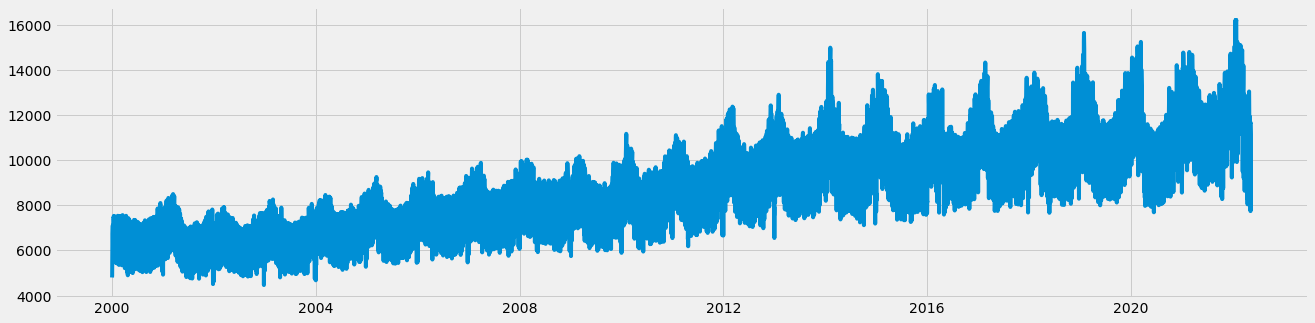

In [22]:
plt.figure(figsize = (20,5))
plt.plot(df_load_sul)
plt.show()

In [ ]:
data = df_load_sul.asfreq('d')

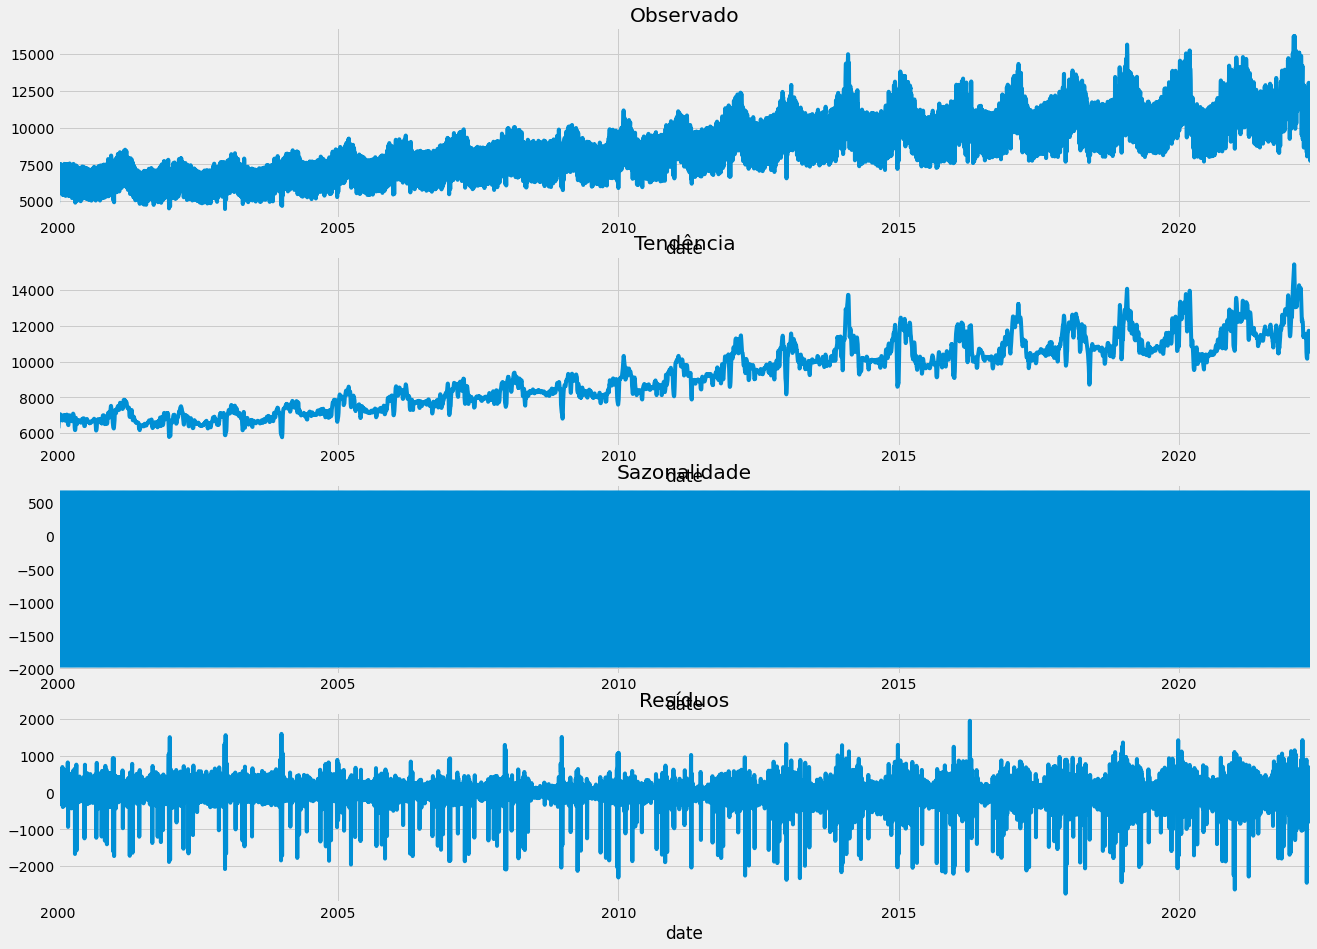

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (20,15))
decompose_data = seasonal_decompose(data, model="additive")

decompose_data.observed.plot(ax = ax1, title = "Observado")
decompose_data.trend.plot(ax = ax2, title = "Tendência")
decompose_data.seasonal.plot(ax = ax3, title = "Sazonalidade")
decompose_data.resid.plot(ax = ax4, title = "Resíduos")

plt.show()

## MODELAGEM

In [52]:
import statsmodels.api as sm

In [57]:
model = sm.tsa.statespace.SARIMAX(data,order=(1, 1, 1),seasonal_order=(1,1,1,7))
results = model.fit()

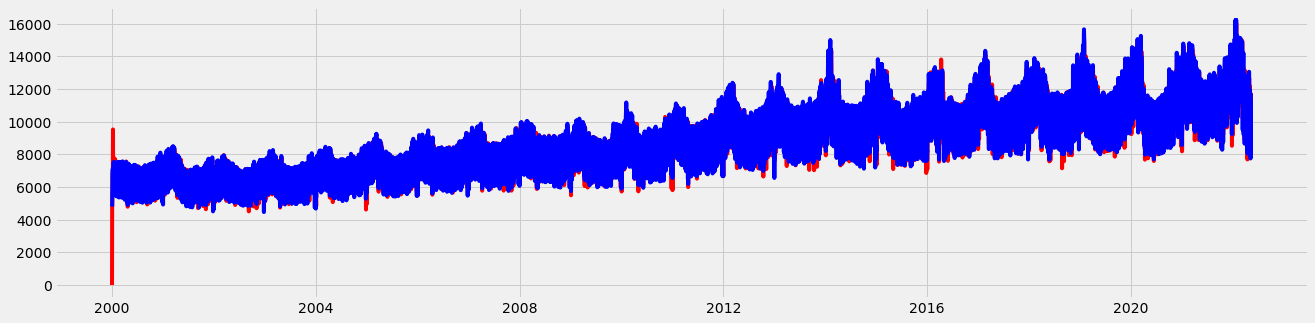

In [63]:
plt.figure(figsize = (20,5))

plt.plot(results.predict(), c = "red")
plt.plot(df_load_sul, c = "blue")

plt.show()

In [65]:
results.forecast(7)

2022-05-12    11595.543386
2022-05-13    11382.255354
2022-05-14     9793.307838
2022-05-15     8491.069733
2022-05-16    11266.590178
2022-05-17    11731.100975
2022-05-18    11826.107744
Freq: D, Name: predicted_mean, dtype: float64

## COM DIVISÃO DE TREINO E TESTE

In [67]:
df_load_sul.tail()

,load_mwmed
date,
2022-05-07,9335.042167
2022-05-08,7743.530417
2022-05-09,10809.693083
2022-05-10,11654.623500
2022-05-11,11609.633333


In [73]:
train, test = df_load_sul.iloc[:-30], df_load_sul.iloc[-30:] 

In [74]:
train.tail()

,load_mwmed
date,
2022-04-07,12512.483583
2022-04-08,12271.662917
2022-04-09,10395.100000
2022-04-10,9137.307083
2022-04-11,11983.965833


In [75]:
test.head()

,load_mwmed
date,
2022-04-12,12160.468250
2022-04-13,12080.641000
2022-04-14,11381.112708
2022-04-15,8310.664667
2022-04-16,8604.080542


In [76]:
model = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,7))
results = model.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [84]:
fc = results.forecast(30)
fc.index = test.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


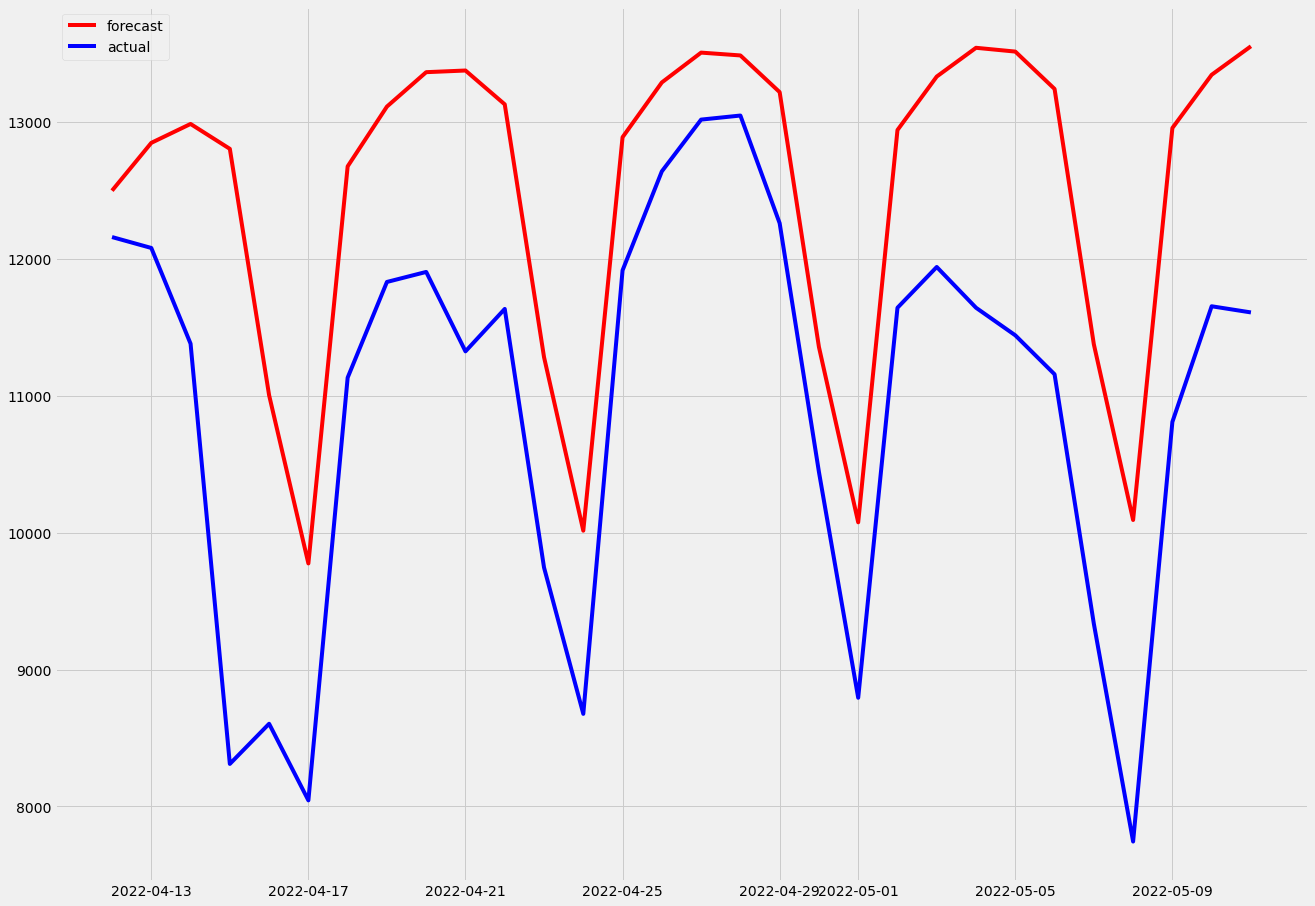

In [87]:
plt.figure(figsize = (20, 15))

plt.plot(fc, c = "red", label = "forecast")
plt.plot(test, c = "blue", label = "actual")

plt.legend()

plt.show()

In [105]:
forecast_errors = [test.iloc[i][0] - fc.iloc[i] for i in range(len(test))]

In [116]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, fc)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, fc)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, fc)
rmse = sqrt(mse)

def sMAPE(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

smape = sMAPE(test.values, fc.values)


## GRID SEARCH

In [126]:
train, test = df_load_sul.iloc[:-30], df_load_sul.iloc[-30:] 

In [121]:
sarmas = [1, 2, 3, 4, 5, 6, 7]
ds = [1, 2]

In [124]:
orders = []
for p in sarmas:
    for d in ds:
        for q in sarmas:
            for P in sarmas:
                for D in ds:
                    for Q in sarmas:
                        l_orders = [p, d, q, P, D, Q]
                        orders.append(l_orders)

In [134]:
models_performance = []
for p,d,q,P,D,Q in orders:
    model = sm.tsa.statespace.SARIMAX(train,order=(p, d, q),seasonal_order=(P,D,Q,7))
    results = model.fit()
    fc = results.forecast(30)
    fc.index = test.index
    forecast_errors = [test.iloc[i][0] - fc.iloc[i] for i in range(len(test))]
    mae = mean_absolute_error(test, fc)
    mse = mean_squared_error(test, fc)
    rmse = sqrt(mse)
    smape = sMAPE(test.values, fc.values)
    m_aic = results.aic
    m_aicc = results.aicc
    m_bic = results.bic
    name = '_'.join([str(p),str(d),str(q),str(P),str(D),str(Q)])
    new_line = [{
                 "model": name,
                 "errors": forecast_errors,
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "smape": smape,
                 "m_aic": m_aic,
                 "m_aicc": m_aicc,
                 "m_bic": m_bic
                 }]
    models_performance.append(new_line)
    print("Done:", new_line)


Done: [{'model': '1_1_1_1_1_1', 'errors': [-338.89790972746414, -768.0100614508883, -1605.7216499388178, -4494.286277490981, -2400.389210065301, -1731.300361471387, -1543.6181863378351, -1281.5069849786778, -1459.5864974880024, -2052.089581926237, -1494.8567177173227, -1537.378495692261, -1338.4384019377649, -972.8358733629848, -649.7595878357424, -489.45151581416394, -439.1748075372725, -957.9034731846914, -913.0907376375599, -1281.9927911802897, -1298.4514417768914, -1391.515909792044, -1899.3608935704688, -2073.1829420150407, -2085.027277571722, -2041.8925614776053, -2349.5320476526276, -2147.365437180162, -1691.3908917482568, -1944.8250314058932], 'mae': 1555.7611185655448, 'mse': 3033734.5460777637, 'rmse': 1741.7619085505814, 'smape': 13.793665865590466, 'm_aic': 121972.12272985306, 'm_aicc': 121972.13011537743, 'm_bic': 122007.13931086576}]
Done: [{'model': '1_1_1_1_1_2', 'errors': [-364.19761223638307, -750.5455664761794, -1480.6683167965293, -4373.558054707437, -2277.929484770